In [1]:
import os
os.environ["NUMBAPRO_NVVM"] = "/usr/local/cuda/nvvm/lib64/libnvvm.so"
os.environ["NUMBAPRO_LIBDEVICE"] = "/usr/local/cuda/nvvm/libdevice/"
os.environ["NUMBA_ENABLE_AVX"] = "0"
os.environ["NUMBA_DUMP_ASSEMBLY"] = "0"

import sys
sys.path.append("../")
import hepaccelerate
import hepaccelerate.backend_cpu as hab
import numba
import numpy
import numpy as np
import uproot

import numba.cuda
from numba import types
from numba.typed import Dict
import json
import cupy

In [2]:
dd = uproot.open("/nvmedata/store/data/Run2017E/SingleMuon/NANOAOD/Nano14Dec2018-v1/10000/FCD50135-3590-2245-BA35-EFE64788BD9A.root")

In [3]:
arrs = dd.get("Events").arrays(["Jet_pt", "Jet_eta"])

In [4]:
s = ""
for x in arrs[b"Jet_pt"].content[:19]:
    s += " {0:.2f}".format(x)
print(s)

 55.41 43.84 19.12 15.89 45.62 26.17 21.55 19.59 19.03 18.73 17.50 15.41 49.56 18.11 16.92 21.17 20.55 17.70 16.34


In [5]:
arrs[b"Jet_pt"].offsets[:20]

array([  0,   4,  12,  15,  20,  30,  33,  38,  39,  45,  54,  58,  65,
        75,  84,  90,  98, 105, 111, 116])

In [6]:
for i in range(4):
    print([round(x, 2) for x in arrs[b"Jet_pt"][i]])

[55.41, 43.84, 19.12, 15.89]
[45.62, 26.17, 21.55, 19.59, 19.03, 18.73, 17.5, 15.41]
[49.56, 18.11, 16.92]
[21.17, 20.55, 17.7, 16.34, 16.11]


In [7]:
arrs[b"Jet_pt"].offsets[:5]

array([ 0,  4, 12, 15, 20])

In [8]:
data = arrs[b"Jet_pt"].content
offsets = arrs[b"Jet_pt"].offsets
out = np.zeros(len(offsets)-1, dtype=np.float32)

In [9]:
def sum_ht_naive(data, offsets, out):
    for iev in range(len(offsets)-1):
        j1 = offsets[iev] #start of event
        j2 = offsets[iev+1] #end of event
        out[iev] = numpy.sum(data[j1:j2])

In [10]:
%timeit sum_ht_naive(data, offsets, out)

6.65 s ± 424 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [11]:
@numba.njit(parallel=True, fastmath=True)
def sum_ht_numba(data, offsets, out):
    for iev in numba.prange(len(offsets)-1):
        j1 = offsets[iev] #start of event
        j2 = offsets[iev+1] #end of event
        for j in range(j1, j2):
            out[iev] += data[j]

In [12]:
sum_ht_numba(data, offsets, out)

In [13]:
out[:] = 0
%timeit sum_ht_numba(data, offsets, out)

4.98 ms ± 505 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [14]:
@numba.cuda.jit()
def sum_ht_cuda(data, offsets, out):
    xi = numba.cuda.grid(1)
    xstride = numba.cuda.gridsize(1)
    
    for iev in range(xi, len(offsets)-1, xstride):
        j1 = offsets[iev] #start of event
        j2 = offsets[iev+1] #end of event
        for j in range(j1, j2):
            out[iev] += data[j]

In [15]:
out[:] = 0
data_c = cupy.array(data)
offsets_c = cupy.array(offsets)
out_c = cupy.array(out)

In [16]:
%timeit sum_ht_cuda[32,1024](data_c, offsets_c, out_c)

757 µs ± 50.7 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [47]:
cc0 = [5.53E+04, 5.26E+04, 5.21E+04, 4.34E+04, 5.12E+04, 5.50E+04, 4.83E+04, 5.82E+04, 5.75E+04, 5.89E+04, 5.62E+04, 5.11E+04, 4.72E+04, 5.12E+04, 4.87E+04, 4.57E+04, 4.84E+04, 4.76E+04, 4.70E+04, 4.53E+04, 5.25E+04, 5.02E+04, 5.57E+04, 5.28E+04, 5.26E+04, 4.92E+04, 4.65E+04, 5.32E+04, 5.27E+04, 5.22E+04, 6.11E+04, 5.79E+04, 5.60E+04, 4.75E+04, 4.93E+04, 4.56E+04, 5.22E+04, 4.12E+04, 4.78E+04, 4.88E+04, 4.61E+04, 5.27E+04, 4.80E+04, 4.90E+04, 4.82E+04, 6.18E+04, 5.44E+04, 5.37E+04, 5.30E+04, 5.41E+04, 5.06E+04, 6.01E+04, 5.38E+04, 5.93E+04, 5.87E+04, 4.97E+04, 5.01E+04, 4.85E+04, 4.64E+04, 5.02E+04, 4.39E+04, 4.67E+04, 4.94E+04, 4.56E+04, 4.74E+04, 4.47E+04, 5.25E+04, 5.52E+04, 5.69E+04, 5.29E+04, 5.10E+04, 5.01E+04, 6.05E+04, 5.39E+04, 5.81E+04, 6.09E+04, 5.75E+04, 4.86E+04, 4.77E+04, 4.97E+04, 5.02E+04, 5.03E+04, 5.10E+04, 4.14E+04, 4.76E+04, 4.97E+04, 4.57E+04, 5.13E+04, 5.21E+04, 5.37E+04, 5.41E+04, 5.21E+04, 5.27E+04, 5.37E+04, 5.10E+04, 5.71E+04, 5.49E+04, 6.22E+04, 5.56E+04, 4.71E+04, 4.83E+04, 4.74E+04, 4.91E+04, 4.72E+04, 4.99E+04, 4.58E+04, 4.69E+04, 4.78E+04, 4.21E+04, 5.03E+04, 4.68E+04, 5.75E+04, 5.35E+04, 5.32E+04, 5.37E+04, 5.32E+04, 5.43E+04, 5.28E+04, 5.88E+04, 5.90E+04, 5.64E+04, 4.89E+04, 4.66E+04, 4.95E+04, 4.83E+04, 4.67E+04, 4.88E+04, 4.52E+04, 4.79E+04, 4.97E+04, 5.14E+04, 5.36E+04, 4.84E+04, 5.16E+04, 5.60E+04, 5.08E+04, 5.52E+04, 5.19E+04, 5.00E+04, 5.44E+04, 5.42E+04, 6.01E+04, 5.55E+04, 5.63E+04, 4.62E+04, 4.69E+04, 5.22E+04, 4.59E+04, 4.87E+04, 4.92E+04, 4.51E+04, 4.84E+04, 4.87E+04, 5.00E+04, 5.48E+04, 5.25E+04, 5.38E+04, 5.27E+04, 5.36E+04, 5.93E+04, 5.88E+04, 5.67E+04, 5.49E+04, 4.61E+04, 4.61E+04, 4.87E+04, 4.37E+04, 4.49E+04, 4.88E+04, 4.50E+04, 4.72E+04, 5.17E+04, 4.89E+04, 4.64E+04, 5.62E+04, 5.87E+04, 5.41E+04, 5.42E+04, 5.33E+04, 5.09E+04, 5.22E+04, 5.32E+04, 6.15E+04, 6.08E+04, 6.12E+04, 4.56E+04, 4.44E+04, 4.50E+04, 4.78E+04, 4.32E+04, 4.79E+04, 4.40E+04, 4.50E+04, 5.00E+04, 4.81E+04, 5.15E+04, 5.22E+04, 5.65E+04, 5.51E+04, 1.30E+04, 5.54E+04, 5.15E+04, 5.05E+04, 5.23E+04, 5.29E+04, 5.34E+04, 5.38E+04, 5.97E+04, 5.41E+04, 4.88E+04, 4.86E+04, 4.57E+04, 4.70E+04, 4.79E+04, 4.55E+04, 4.89E+04, 5.26E+04, 4.61E+04, 4.67E+04, 4.56E+04, 5.69E+04, 5.17E+04, 5.33E+04, 5.54E+04, 5.18E+04, 5.09E+04, 5.53E+04, 5.57E+04, 5.99E+04, 4.89E+04, 5.87E+04, 4.50E+04, 5.13E+04, 4.94E+04, 4.35E+04, 4.97E+04, 5.17E+04, 5.11E+04, 5.08E+04, 4.91E+04, 4.90E+04, 5.47E+04, 5.43E+04, 5.26E+04, 5.39E+04, 5.41E+04, 5.03E+04, 5.12E+04, 5.38E+04, 5.46E+04, 6.14E+04, 5.72E+04, 5.02E+04, 5.10E+04, 4.87E+04, 4.70E+04, 4.61E+04, 5.03E+04, 5.15E+04, 5.04E+04, 5.14E+04, 4.99E+04, 5.26E+04, 4.90E+04, 5.44E+04, 5.04E+04, 5.63E+04, 5.49E+04, 5.82E+04, 5.37E+04, 4.82E+04, 4.83E+04, 5.91E+04, 5.40E+04, 5.98E+04, 5.57E+04, 5.66E+04, 5.82E+04, 4.40E+04, 5.12E+04, 5.14E+04, 4.50E+04, 5.04E+04, 5.00E+04, 5.37E+04, 5.60E+04, 5.15E+04, 6.35E+04, 4.99E+04, 5.16E+04, 4.85E+04, 5.18E+04, 5.07E+04, 6.05E+04, 5.49E+04, 6.00E+04, 6.06E+04, 5.77E+04, 6.15E+04, 4.94E+04, 4.71E+04, 4.22E+04, 4.85E+04, 4.76E+04, 4.46E+04, 4.72E+04, 4.61E+04, 4.64E+04, 5.38E+04, 4.83E+04, 4.32E+04, 5.12E+04, 5.62E+04, 5.38E+04, 5.27E+04, 5.25E+04, 5.43E+04, 4.65E+04, 5.77E+04, 5.36E+04, 6.18E+04, 5.97E+04, 4.94E+04, 4.78E+04, 4.68E+04, 4.84E+04, 4.82E+04, 4.88E+04, 4.77E+04, 4.98E+04, 5.02E+04, 4.61E+04, 6.97E+04, 5.58E+04, 5.27E+04, 5.49E+04, 5.07E+04, 5.29E+04, 5.48E+04, 5.30E+04, 5.94E+04, 5.62E+04, 5.23E+04, 6.10E+04, 4.44E+04, 4.95E+04, 5.04E+04, 4.54E+04, 4.94E+04, 4.93E+04, 4.56E+04, 4.48E+04, 4.90E+04, 5.17E+04, 5.05E+04, 4.86E+04, 5.03E+04, 6.17E+04, 4.45E+04, 5.87E+04, 5.96E+04, 1.29E+04, 3.26E+04, 2.00E+04, 2.07E+03, 2.03E+03, 2.01E+04, 5.15E+03, 2.04E+04, 7.22E+02, 2.20E+04, 1.39E+04, 5.68E+03, 1.96E+04, 2.30E+04, 1.62E+03, 2.47E+04, 1.33E+04, 1.86E+04, 3.72E+04, 1.07E+04, 4.23E+04, 2.45E+04, 3.31E+04, 2.91E+04, 4.23E+04, 4.93E+04, 3.84E+04, 3.33E+04, 4.91E+04, 3.57E+04, 1.45E+03, 5.10E+04, 4.63E+04, 4.84E+04, 4.41E+04, 4.08E+04, 3.81E+04, 4.38E+04, 4.44E+04, 4.58E+04, 4.44E+04, 4.40E+04, 4.77E+04, 4.92E+04, 4.45E+04, 4.69E+04, 4.43E+04, 4.66E+04, 4.51E+04, 4.45E+04, 3.80E+04, 4.71E+04, 5.05E+04, 3.95E+04, 4.50E+04, 4.58E+04, 4.74E+04, 4.27E+04, 4.50E+04, 4.79E+04, 4.84E+04, 4.02E+04, 4.46E+04, 3.53E+04, 4.73E+04, 4.49E+04, 4.54E+04, 4.68E+04, 4.45E+04, 4.57E+04, 4.58E+04, 4.57E+04, 4.55E+04, 4.61E+04, 4.58E+04, 4.53E+04, 4.96E+04, 4.62E+04, 3.63E+04, 4.23E+04, 4.77E+04, 4.40E+04, 4.51E+04, 4.61E+04, 4.67E+04, 4.23E+04, 4.28E+04, 4.74E+04, 4.41E+04, 4.50E+04, 4.83E+04, 5.07E+04, 4.85E+04, 4.57E+04, 4.62E+04, 4.49E+04, 4.78E+04, 4.58E+04, 4.47E+04, 4.30E+04, 4.73E+04, 4.10E+04, 4.30E+04, 4.86E+04, 4.43E+04, 3.80E+04, 5.02E+04, 3.80E+04, 4.57E+04, 4.94E+04, 4.31E+04, 4.61E+04, 4.38E+04, 3.71E+04, 5.47E+04, 4.58E+04, 4.62E+04, 4.92E+04, 4.45E+04, 4.56E+04, 4.91E+04, 5.71E+04, 4.08E+04, 4.43E+04, 4.61E+04, 4.36E+04, 4.26E+04, 4.30E+04, 6.05E+04, 4.21E+04, 4.41E+04, 4.81E+04, 4.54E+04, 4.56E+04, 4.65E+04, 4.61E+04, 6.15E+04, 4.42E+04, 4.36E+04, 4.97E+04, 4.30E+04, 4.45E+04, 4.25E+04, 4.68E+04, 5.89E+04, 4.26E+04, 4.49E+04, 4.48E+04, 4.32E+04, 4.34E+04, 4.70E+04, 4.34E+04, 5.34E+04, 3.65E+04, 3.66E+04, 3.78E+04, 3.63E+04, 3.63E+04, 3.50E+04, 4.01E+04, 3.80E+04, 3.87E+04, 2.76E+04, 2.82E+04, 2.69E+04, 2.51E+04, 2.65E+04, 2.72E+04, 2.50E+04, 2.81E+04, 2.60E+04, 2.76E+04, 2.70E+04, 3.06E+04, 2.44E+04, 2.68E+04, 2.89E+04, 2.41E+04, 2.87E+04, 2.69E+04, 2.86E+04, 2.58E+04, 2.98E+04, 2.64E+04, 3.06E+04, 2.66E+04, 3.14E+04, 2.65E+04, 2.81E+04, 2.52E+04, 3.16E+04, 2.67E+04, 3.12E+04, 2.38E+04, 3.23E+04, 2.87E+04, 3.29E+04, 6.59E+04, 6.72E+04, 1.31E+04, 6.03E+04, 6.77E+04, 2.99E+04, 3.84E+04, 3.25E+04, 3.55E+04, 3.30E+04, 3.86E+04, 3.32E+04, 3.65E+04, 3.53E+04, 3.87E+04, 3.95E+04, 3.97E+04, 3.76E+04, 3.77E+04, 3.75E+04, 3.69E+04, 3.67E+04, 2.65E+04, 3.63E+04, 4.00E+04, 3.89E+04, 3.92E+04, 3.65E+04, 3.82E+04, 3.80E+04, 4.02E+04, 3.78E+04, 4.09E+04, 3.97E+04, 3.96E+04, 4.13E+04, 4.15E+04, 4.05E+04, 4.96E+04, 4.36E+04, 5.50E+04, 6.08E+04, 6.19E+04, 5.61E+04, 5.83E+04, 6.02E+04, 5.72E+04]

In [48]:
cc1 = [
3.98E+06
,3.14E+06
,3.79E+06
,2.97E+06
,3.69E+06
,2.98E+06
,3.44E+06
,3.23E+06
,3.42E+06
,2.86E+06
,3.88E+06
,3.96E+06
,3.37E+06
,3.35E+06
,3.77E+06
,3.57E+06
,4.40E+06
,3.31E+06
,3.06E+06
,2.90E+06
,3.58E+06
,3.41E+06
,4.48E+06
,3.38E+06
,2.96E+06
,2.97E+06
,3.79E+06
,3.68E+06
,3.37E+06
,4.54E+06
,4.82E+06
,3.51E+06
,3.78E+06
,2.75E+06
,2.99E+06
,6.53E+05
,3.49E+06
,3.83E+06
,3.63E+06
,4.61E+06
,3.33E+06
,2.91E+06
,3.42E+06
,3.82E+06
,2.97E+06
,3.75E+06
,4.60E+06
,3.71E+06
,3.80E+06
,3.30E+06
,3.64E+06
,4.68E+06
,3.98E+06
,3.48E+06
,3.61E+06
,3.49E+06
,4.11E+06
,2.77E+06
,4.35E+06
,3.52E+06
,3.74E+06
,3.03E+06
,4.12E+06
,3.22E+06
,3.91E+06
,3.57E+06
,3.03E+06
,3.42E+06
,3.61E+06
,3.78E+06
,1.95E+06
,3.53E+06
,3.82E+06
,3.79E+06
,3.24E+06
,3.26E+06
,3.11E+06
,4.01E+06
,4.27E+06
,3.49E+06
,4.67E+06
,4.16E+06
,3.61E+06
,3.84E+06
,3.46E+06
,3.00E+06
,4.01E+06
,3.70E+06
,3.35E+06
,3.64E+06
,3.46E+06
,3.76E+06
,3.52E+06
,3.25E+06
,4.09E+06
,4.33E+06
,3.61E+06
,4.48E+06
,3.15E+06
,3.50E+06
,3.30E+06
,4.36E+06
,3.31E+06
,4.02E+06
,3.39E+06
,4.77E+06
,3.99E+06
,3.88E+06
,4.48E+06
,3.95E+06
,4.46E+06
,3.93E+06
,2.56E+06
,3.33E+06
,4.69E+06
,3.89E+06
,3.84E+06
,3.45E+06
,3.19E+06
,4.36E+06
,4.76E+06
,3.17E+06
,3.65E+06
,3.36E+06
,3.79E+06
,3.95E+06
,3.70E+06
,4.57E+06
,3.86E+06
,3.15E+06
,3.82E+06
,3.61E+06
,4.08E+06
,4.94E+06
,3.45E+06
,3.90E+06
,3.60E+06
,4.71E+06
,3.62E+06
,3.57E+06
,4.87E+06
,3.75E+06
,3.85E+06
,4.24E+06
,4.46E+06
,4.57E+06
,4.95E+06
,4.33E+06
,3.81E+06
,4.16E+06
,4.49E+06
,4.55E+06
,3.96E+06
,4.38E+06
,3.34E+06
,3.97E+06
,3.54E+06
,4.01E+06
,4.17E+06
,3.67E+06
,4.66E+06
,4.14E+06
,3.25E+06
,4.57E+06
,4.15E+06
,4.13E+06
,3.34E+06
,3.71E+06
,4.82E+06
,3.34E+06
,3.63E+06
,3.35E+06
,3.65E+06
,3.02E+06
,3.44E+06
,3.14E+06
,2.99E+06
,3.11E+06
,3.80E+06
,3.08E+06
,3.49E+06
,2.68E+06
,3.00E+06
,2.97E+06
,2.91E+06
,3.07E+06
,3.57E+06
,2.90E+06
,2.96E+06
,3.21E+06
,3.72E+06
,2.69E+06
,2.90E+06
,2.94E+06
,3.50E+06
,3.91E+06
,3.26E+06
,3.15E+06
,3.77E+06
,3.36E+06
,2.94E+06
,3.33E+06
,2.79E+06
,2.85E+06
,3.47E+06
,3.39E+06
,3.35E+06
,3.41E+06
,2.40E+06
,3.23E+06
,2.66E+06
,2.85E+06
,3.15E+06
,3.34E+06
,2.79E+06
,3.19E+06
,2.99E+06
,3.29E+06
,2.86E+06
,3.08E+06
,2.91E+06
,3.54E+06
,2.94E+06
,3.10E+06
,2.74E+06
,2.85E+06
,3.39E+06
,3.35E+06
,1.02E+06
,3.24E+06
,3.17E+06
,2.59E+06
,3.61E+06
,3.59E+06
,2.43E+06
,2.97E+06
,3.09E+06
,2.92E+06
,3.64E+06
,3.17E+06
,2.96E+06
,3.19E+06
,3.45E+06
,3.08E+06
,3.24E+06
,2.49E+06
,2.68E+06
,3.72E+06
,3.33E+06
,3.04E+06
,3.45E+06
,2.80E+06
,3.20E+06
,3.54E+06
,3.26E+06
,3.52E+06
,2.92E+06
,3.01E+06
,3.23E+06
,2.85E+06
,3.28E+06
,3.56E+06
,2.53E+06
,2.82E+06
,3.42E+06
,3.33E+06
,2.70E+06
,3.00E+06
,3.65E+06
,3.37E+06
,3.44E+06
,3.28E+06
,2.78E+06
,3.89E+06
,3.06E+06
,2.84E+06
,3.23E+06
,3.51E+06
,3.06E+06
,3.06E+06
,2.62E+06
,3.52E+06
,2.97E+06
,3.35E+06
,3.39E+06
,3.03E+06
,3.03E+06
,3.14E+06
,3.19E+06
,4.05E+06
,2.79E+06
,2.96E+06
,3.36E+06
,2.82E+06
,3.13E+06
,3.03E+06
,3.29E+06
,3.51E+06
,3.04E+06
,3.04E+06
,3.37E+06
,3.27E+06
,3.05E+06
,2.71E+06
,3.94E+06
,3.36E+06
,3.02E+06
,2.49E+06
,3.38E+06
,3.09E+06
,3.62E+06
,3.00E+06
,3.76E+06
,3.36E+06
,3.23E+06
,3.60E+06
,3.06E+06
,3.75E+06
,3.34E+06
,3.66E+06
,3.06E+06
,3.24E+06
,3.38E+06
,2.93E+06
,3.52E+06
,3.59E+06
,3.38E+06
,3.55E+06
,3.49E+06
,2.99E+06
,3.24E+06
,3.43E+06
,3.78E+06
,3.38E+06
,2.98E+06
,3.29E+06
,3.92E+06
,3.85E+06
,3.49E+06
,3.66E+06
,3.19E+06
,2.74E+06
,2.88E+06
,2.87E+06
,3.10E+06
,3.03E+06
,3.77E+06
,3.54E+06
,4.36E+06
,3.84E+06
,3.61E+06
,3.36E+06
,3.23E+06
,2.91E+06
,3.00E+06
,3.31E+06
,3.69E+06
,3.43E+06
,1.91E+06
,7.97E+05
,2.00E+06
,4.95E+05
,1.71E+05
,1.97E+05
,3.05E+05
,4.25E+04
,5.18E+04
,1.45E+05
,8.36E+05
,2.72E+05
,2.10E+05
,3.31E+05
,3.76E+05
,4.37E+05
,1.04E+05
,3.27E+05
,2.13E+04
,3.26E+05
,4.02E+05
,1.45E+04
,6.60E+05
,7.78E+04
,6.17E+05
,5.11E+05
,7.83E+05
,1.64E+06
,7.79E+05
,1.22E+06
,1.27E+06
,5.52E+05
,6.56E+05
,4.54E+04
,9.67E+05
,1.31E+06
,2.83E+06
,3.47E+06
,3.69E+06
,3.12E+06
,3.28E+06
,3.01E+06
,2.93E+06
,2.92E+06
,3.21E+06
,2.60E+06
,3.70E+06
,3.67E+06
,4.28E+06
,3.28E+06
,3.56E+06
,2.92E+06
,2.88E+06
,3.70E+06
,3.30E+06
,3.04E+06
,3.26E+06
,3.84E+06
,3.29E+06
,4.10E+06
,3.39E+06
,3.97E+06
,2.54E+06
,3.54E+06
,4.09E+06
,3.68E+06
,3.13E+06
,3.11E+06
,3.04E+06
,3.29E+06
,3.03E+06
,2.83E+06
,2.97E+06
,3.23E+06
,4.19E+06
,3.84E+06
,2.86E+06
,3.99E+06
,3.45E+06
,3.46E+06
,3.14E+06
,3.59E+06
,2.00E+06
,3.46E+06
,3.32E+06
,3.17E+06
,3.15E+06
,2.91E+06
,3.41E+06
,3.98E+06
,3.99E+06
,1.20E+06
,2.98E+06
,3.73E+06
,3.81E+06
,2.73E+06
,3.57E+06
,3.30E+06
,2.79E+06
,3.16E+06
,2.91E+06
,3.44E+06
,3.43E+06
,2.72E+06
,3.48E+06
,3.58E+06
,1.19E+06
,4.22E+06
,3.59E+06
,3.88E+06
,2.48E+06
,3.16E+06
,3.22E+06
,3.71E+06
,3.16E+06
,3.75E+06
,2.97E+06
,3.04E+06
,3.98E+06
,3.79E+06
,3.59E+06
,3.35E+06
,3.70E+06
,3.67E+06
,3.13E+06
,3.17E+06
,3.73E+06
,2.71E+06
,3.97E+06
,3.46E+06
,3.30E+06
,2.58E+06
,3.63E+06
,3.25E+06
,3.66E+06
,3.28E+06
,3.80E+06
,3.33E+06
,2.44E+06
,4.16E+06
,3.62E+06
,3.70E+06
,3.56E+06
,3.41E+06
,3.72E+06
,3.54E+06
,3.51E+06
,3.81E+06
,4.12E+06
,3.67E+06
,2.16E+06
,2.82E+06
,1.85E+06
,1.35E+06
,4.07E+06
,3.66E+06
,2.14E+06
,2.13E+06
,1.91E+06
,2.22E+06
,2.05E+06
,1.65E+06
,1.83E+06
,1.99E+06
,1.90E+06
,2.59E+06
,2.29E+06
,1.99E+06
,1.84E+06
,2.12E+06
,1.75E+06
,1.89E+06
,1.95E+06
,1.43E+06
,1.80E+06
,2.01E+06
,2.13E+06
,2.12E+06
,1.86E+06
,1.86E+06
,2.04E+06
,1.52E+06
,1.13E+06
,1.92E+06
,2.09E+06
,2.05E+06
,1.88E+06
,1.88E+06
,2.24E+06
,2.09E+06
,2.00E+06
,1.87E+06
,2.22E+06
,1.99E+06
,1.70E+06
,1.66E+06
,1.96E+06
,8.41E+05
,1.89E+06
,1.12E+06
,2.79E+06
,2.41E+06
,3.01E+06
,1.10E+05
,1.29E+06
,2.53E+06
,2.49E+06
,2.49E+06
,2.31E+06
,2.97E+06
,2.79E+06
,2.85E+06
,2.59E+06
,2.95E+06
,2.49E+06
,2.52E+06
,2.61E+06
,2.38E+06
,2.48E+06
,2.94E+06
,2.61E+06
,2.57E+06
,3.10E+06
,2.54E+06
,2.61E+06
,2.67E+06
,2.88E+06
,2.00E+06
,3.04E+06
,2.21E+06
,2.43E+06
,2.40E+06
,7.12E+05
,2.69E+06
,2.88E+06
,2.66E+06
,3.25E+06
,2.83E+06
,2.37E+06
,2.63E+06
,9.13E+05
,3.23E+06
,3.10E+06
,1.70E+06
,2.58E+06
,2.76E+06
,3.26E+06
]

In [30]:
cc2 = [1.18E+06, 3.72E+06, 4.97E+06, 3.92E+06, 5.40E+06, 5.35E+06, 4.90E+06, 4.14E+06, 5.08E+06, 4.93E+06, 5.14E+06, 4.25E+06, 5.14E+06, 4.36E+06, 5.50E+06, 5.02E+06, 5.87E+06, 5.47E+06, 5.01E+06, 4.78E+06, 5.68E+06, 5.03E+06, 5.63E+06, 4.88E+06, 3.62E+06, 3.51E+06, 5.01E+06, 4.81E+06, 5.70E+06, 4.88E+06, 5.29E+06, 5.10E+06, 5.45E+06, 4.71E+06, 4.13E+06, 4.06E+06, 5.84E+06, 4.78E+06, 5.28E+06, 5.00E+06, 5.40E+06, 4.41E+06, 5.34E+06, 4.54E+06, 5.31E+06, 4.58E+06, 5.50E+06, 4.59E+06, 5.13E+06, 4.58E+06, 5.04E+06, 4.71E+06, 4.98E+06, 4.36E+06, 5.11E+06, 4.23E+06, 4.70E+06, 4.75E+06, 5.13E+06, 4.82E+06, 5.23E+06, 4.44E+06, 5.59E+06, 5.13E+06, 5.46E+06, 4.97E+06, 5.06E+06, 4.83E+06, 4.98E+06, 4.70E+06, 1.84E+05, 1.77E+05, 5.39E+06, 4.89E+06, 5.22E+06, 4.12E+06, 4.79E+06, 4.37E+06, 5.62E+06, 5.05E+06, 5.42E+06, 4.72E+06, 4.66E+06, 3.82E+06, 5.60E+06, 4.84E+06, 5.15E+06, 4.68E+06, 5.22E+06, 4.48E+06, 4.91E+06, 4.92E+06, 5.57E+06, 4.95E+06, 5.54E+06, 4.92E+06, 5.20E+06, 4.29E+06, 5.17E+06, 4.87E+06, 5.01E+06, 4.60E+06, 5.40E+06, 4.97E+06, 5.58E+06, 4.57E+06, 4.79E+06, 3.94E+06, 5.18E+06, 4.74E+06, 5.21E+06, 4.53E+06, 5.61E+06, 5.15E+06, 3.62E+06, 2.40E+06, 5.67E+06, 5.21E+06, 4.69E+06, 4.00E+06, 4.63E+06, 4.39E+06, 5.22E+06, 4.54E+06, 5.24E+06, 4.69E+06, 5.47E+06, 4.89E+06, 4.78E+06, 4.00E+06, 5.52E+06, 4.67E+06, 4.62E+06, 4.36E+06, 4.26E+06, 3.92E+06, 5.12E+06, 4.69E+06, 5.40E+06, 4.47E+06, 2.71E+06, 2.42E+06, 4.59E+06, 4.33E+06, 5.59E+06, 4.90E+06, 5.27E+06, 4.53E+06, 3.81E+06, 4.02E+06, 4.88E+06, 4.25E+06, 4.89E+06, 4.48E+06, 5.54E+06, 4.86E+06, 5.06E+06, 5.19E+06, 5.18E+06, 4.80E+06, 5.13E+06, 4.89E+06, 5.20E+06, 4.62E+06, 4.76E+06, 4.44E+06, 5.36E+06, 4.86E+06, 4.26E+06, 3.33E+06, 4.00E+06, 3.76E+06, 5.13E+06, 4.34E+06, 5.59E+06, 4.81E+06, 4.79E+06, 4.35E+06, 5.47E+06, 4.61E+06, 4.53E+06, 3.92E+06, 4.05E+06, 3.55E+06, 4.24E+06, 3.93E+06, 3.94E+06, 3.49E+06, 4.98E+06, 4.22E+06, 4.59E+06, 3.73E+06, 5.44E+06, 5.37E+06, 5.40E+06, 4.81E+06, 4.27E+06, 3.71E+06, 4.29E+06, 3.28E+06, 4.03E+06, 3.70E+06, 4.82E+06, 4.30E+06, 5.15E+06, 4.78E+06, 4.71E+06, 4.30E+06, 5.33E+06, 4.32E+06, 5.20E+06, 4.18E+06, 4.80E+06, 4.07E+06, 4.34E+06, 3.69E+06, 5.14E+06, 4.48E+06, 5.45E+06, 4.96E+06, 5.46E+06, 4.71E+06, 4.36E+06, 4.25E+06, 3.39E+06, 2.72E+06, 3.98E+06, 3.41E+06, 4.40E+06, 4.00E+06, 5.64E+06, 5.47E+06, 5.27E+06, 4.44E+06, 4.52E+06, 4.54E+06, 5.57E+06, 5.03E+06, 5.08E+06, 4.57E+06, 5.18E+06, 4.41E+06, 5.23E+06, 4.81E+06, 4.43E+06, 4.27E+06, 4.56E+06, 4.07E+06, 4.98E+06, 4.12E+06, 5.39E+06, 4.91E+06, 4.02E+06, 3.66E+06, 4.99E+06, 4.70E+06, 5.41E+06, 4.47E+06, 4.63E+06, 4.31E+06, 4.25E+06, 3.71E+06, 5.13E+06, 4.85E+06, 5.62E+06, 4.68E+06, 5.53E+06, 4.70E+06, 4.48E+06, 3.99E+06, 5.13E+06, 4.65E+06, 4.50E+06, 4.10E+06, 5.45E+06, 4.94E+06, 5.65E+06, 4.75E+06, 5.19E+06, 4.24E+06, 5.08E+06, 4.87E+06, 4.82E+06, 4.30E+06, 5.64E+06, 4.81E+06, 5.15E+06, 4.13E+06, 4.76E+06, 4.25E+06, 5.10E+06, 4.85E+06, 5.85E+06, 5.18E+06, 5.28E+06, 4.45E+06, 5.47E+06, 5.30E+06, 5.62E+06, 5.01E+06, 5.68E+06, 5.23E+06, 5.66E+06, 5.07E+06, 4.80E+06, 4.14E+06, 5.37E+06, 4.54E+06, 4.94E+06, 4.45E+06, 5.40E+06, 4.81E+06, 4.58E+06, 4.05E+06, 4.72E+06, 4.44E+06, 4.49E+06, 4.72E+06, 4.49E+06, 3.39E+06, 5.30E+06, 4.77E+06, 5.55E+06, 4.77E+06, 3.94E+06, 3.55E+06, 4.84E+06, 4.34E+06, 4.39E+06, 3.91E+06, 4.55E+06, 3.73E+06, 4.92E+06, 4.49E+06, 4.34E+06, 3.90E+06, 5.19E+06, 4.64E+06, 4.61E+06, 3.48E+06, 4.31E+06, 4.14E+06, 4.87E+06, 4.61E+06, 4.61E+06, 4.09E+06, 5.09E+06, 4.13E+06, 4.58E+06, 3.59E+06, 4.83E+06, 3.90E+06, 4.29E+06, 3.86E+06, 5.12E+06, 4.59E+06, 4.05E+06, 4.13E+06, 5.36E+06, 4.64E+06, 4.55E+06, 4.03E+06, 5.24E+06, 4.71E+06, 5.13E+06, 4.60E+06, 5.45E+06, 4.88E+06, 4.94E+06, 4.14E+06, 5.11E+06, 4.78E+06, 5.11E+06, 4.79E+06, 5.22E+06, 4.66E+06, 4.21E+06, 4.10E+06, 5.07E+06, 4.82E+06, 4.99E+06, 4.75E+06, 4.87E+06, 4.50E+06, 5.16E+06, 4.80E+06, 5.37E+06, 4.64E+06, 5.72E+06, 4.85E+06, 4.82E+06, 4.19E+06, 4.92E+06, 4.03E+06, 5.30E+06, 4.41E+06, 5.75E+06, 5.20E+06, 4.94E+06, 3.88E+06, 4.89E+06, 3.59E+06, 4.61E+06, 4.31E+06, 5.18E+06, 4.75E+06, 5.48E+06, 4.87E+06, 5.02E+06, 4.39E+06, 5.66E+06, 4.90E+06, 4.72E+06, 4.27E+06, 5.11E+06, 4.43E+06, 4.93E+06, 4.24E+06, 5.37E+06, 4.94E+06, 4.40E+06, 3.69E+06, 4.35E+06, 4.41E+06, 5.35E+06, 4.15E+06, 5.15E+06, 4.80E+06, 4.47E+06, 4.14E+06, 4.73E+06, 4.36E+06, 5.01E+06, 3.88E+06, 5.19E+06, 4.41E+06, 4.24E+06, 3.71E+06, 4.74E+06, 4.13E+06, 4.21E+06, 3.47E+06, 4.26E+06, 3.79E+06, 5.36E+06, 4.86E+06, 4.52E+06, 4.24E+06, 4.16E+06, 3.81E+06, 5.48E+06, 4.58E+06, 4.90E+06, 4.49E+06, 4.88E+06, 4.10E+06, 9.82E+05, 9.86E+05, 4.56E+06, 4.62E+06, 5.25E+06, 4.49E+06, 5.05E+06, 4.81E+06, 4.52E+06, 4.31E+06, 4.48E+06, 4.08E+06, 3.89E+06, 3.01E+06, 4.85E+06, 4.73E+06, 5.30E+06, 4.87E+06, 4.19E+06, 3.47E+06, 5.06E+06, 4.86E+06, 4.82E+06, 4.09E+06, 5.05E+06, 4.45E+06, 5.09E+06, 4.99E+06, 4.72E+06, 4.46E+06, 4.17E+06, 3.73E+06, 4.91E+06, 4.58E+06, 3.63E+06, 3.21E+06, 4.57E+06, 3.81E+06, 5.20E+06, 4.76E+06, 4.78E+06, 4.35E+06, 5.38E+06, 4.50E+06, 4.57E+06, 4.46E+06, 5.39E+06, 4.96E+06, 5.57E+06, 4.80E+06, 5.05E+06, 3.64E+06, 4.48E+06, 4.23E+06, 5.63E+06, 5.06E+06, 5.02E+06, 4.67E+06, 4.54E+06, 4.05E+06, 4.70E+06, 4.51E+06, 4.65E+06, 3.97E+06, 4.87E+06, 4.49E+06, 4.86E+06, 4.39E+06, 4.58E+06, 4.02E+06, 4.42E+06, 3.95E+06, 4.88E+06, 4.55E+06, 4.78E+06, 4.21E+06, 5.20E+06, 4.63E+06, 5.43E+06, 4.77E+06, 4.19E+06, 3.77E+06, 4.49E+06, 3.62E+06, 5.03E+06, 4.87E+06, 4.64E+06, 4.37E+06, 5.48E+06, 5.20E+06, 5.54E+06, 4.26E+06, 5.10E+06, 4.27E+06, 4.31E+06, 4.18E+06, 4.36E+06, 3.96E+06, 4.38E+06, 4.02E+06, 5.27E+06, 4.95E+06, 4.73E+06, 4.00E+06, 5.28E+06, 4.26E+06, 4.28E+06, 3.64E+06, 4.86E+06, 4.73E+06, 4.78E+06, 4.01E+06, 4.46E+06, 3.83E+06, 4.15E+06, 3.94E+06, 4.48E+06, 4.14E+06, 4.44E+06, 4.05E+06, 5.47E+06, 4.84E+06, 4.88E+06, 4.00E+06, 4.80E+06, 4.52E+06, 4.93E+06, 4.41E+06, 5.80E+06, 5.30E+06, 4.25E+06, 3.84E+06, 5.02E+06, 4.26E+06, 5.01E+06, 3.99E+06, 4.60E+06, 3.69E+06, 4.96E+06, 4.59E+06, 5.07E+06, 4.84E+06, 4.75E+06, 3.89E+06, 4.93E+06, 4.84E+06, 5.36E+06, 4.69E+06, 5.42E+06, 4.83E+06, 3.52E+06, 3.61E+06, 5.18E+06, 4.13E+06, 5.09E+06, 4.63E+06, 5.48E+06, 4.72E+06, 3.57E+06, 3.35E+06, 4.97E+06, 4.47E+06, 4.65E+06, 4.55E+06, 5.19E+06, 4.66E+06, 4.99E+06, 4.49E+06, 5.37E+06, 4.69E+06, 4.66E+06, 4.27E+06, 5.22E+06, 4.31E+06, 4.93E+06, 4.43E+06, 4.63E+06, 4.00E+06, 4.66E+06, 4.02E+06, 5.61E+06, 4.68E+06, 5.40E+06, 4.59E+06, 3.95E+06, 3.44E+06, 4.72E+06, 4.72E+06, 5.09E+06, 4.18E+06, 5.06E+06, 4.75E+06, 4.14E+06, 4.70E+06, 5.52E+06, 4.34E+06, 5.20E+06, 4.61E+06, 4.76E+06, 4.43E+06, 4.88E+06, 4.18E+06, 4.72E+06, 3.69E+06, 5.06E+06, 4.51E+06, 5.26E+06, 4.60E+06, 4.98E+06, 4.75E+06, 4.72E+06, 4.64E+06, 5.26E+06, 4.29E+06, 4.99E+06, 4.31E+06, 5.42E+06, 4.33E+06, 5.68E+06, 4.92E+06, 4.98E+06, 4.38E+06, 5.21E+06, 4.74E+06, 4.33E+06, 4.02E+06, 4.31E+06, 4.00E+06, 4.92E+06, 4.31E+06, 4.97E+06, 4.00E+06, 4.83E+06, 4.29E+06, 5.28E+06, 4.42E+06, 4.79E+06, 4.60E+06, 5.22E+06, 4.85E+06, 4.93E+06, 4.54E+06, 5.11E+06, 4.68E+06, 5.14E+06, 4.32E+06, 5.53E+06, 5.14E+06, 5.25E+06, 4.45E+06, 5.15E+06, 4.62E+06, 5.26E+06, 4.70E+06, 4.65E+06, 4.10E+06, 4.91E+06, 4.51E+06, 4.64E+06, 4.34E+06, 9.35E+05, 3.65E+06, 4.49E+05, 3.66E+05, 9.23E+06, 7.56E+06, 4.83E+04, 4.90E+04, 5.53E+04, 5.54E+04, 1.62E+05, 1.28E+05, 1.29E+05, 9.87E+04, 1.42E+04, 1.26E+04, 9.18E+03, 8.06E+03, 8.02E+04, 6.65E+04, 6.22E+05, 5.49E+05, 3.17E+05, 2.61E+05, 1.53E+05, 1.33E+05, 2.83E+05, 2.28E+05, 2.13E+05, 1.82E+05, 3.52E+05, 2.93E+05, 6.98E+04, 5.82E+04, 2.51E+05, 2.13E+05, 1.10E+04, 9.54E+03, 2.88E+05, 2.45E+05, 3.05E+05, 2.45E+05, 1.10E+04, 8.93E+03, 9.18E+05, 7.79E+05, 9.34E+04, 8.19E+04, 4.21E+05, 5.92E+05, 3.66E+05, 3.03E+05, 1.24E+06, 1.04E+06, 1.20E+06, 1.38E+06, 7.69E+05, 6.67E+05, 4.55E+05, 3.86E+05, 1.51E+06, 1.26E+06, 4.77E+05, 3.99E+05, 4.36E+05, 3.55E+05, 4.62E+03, 4.09E+03, 1.23E+06, 1.03E+06, 1.67E+06, 1.34E+06, 6.18E+06, 5.46E+06, 1.05E+07, 9.70E+06, 1.28E+07, 1.11E+07, 1.03E+07, 8.09E+06, 1.04E+07, 9.30E+06, 8.07E+06, 6.93E+06, 1.31E+07, 1.14E+07, 1.05E+07, 8.86E+06, 1.24E+07, 1.08E+07, 9.70E+06, 8.41E+06, 1.08E+07, 9.42E+06, 1.05E+07, 9.45E+06, 1.35E+07, 1.19E+07, 1.10E+07, 9.35E+06, 1.33E+07, 1.14E+07, 1.04E+07, 8.99E+06, 1.12E+07, 9.80E+06, 1.37E+07, 1.21E+07, 1.42E+07, 1.21E+07, 1.43E+07, 1.22E+07, 9.48E+06, 8.35E+06, 1.20E+07, 1.02E+07, 1.03E+07, 9.00E+06, 1.23E+07, 1.12E+07, 1.20E+07, 1.05E+07, 1.02E+07, 9.10E+06, 5.80E+06, 5.19E+06, 1.01E+07, 8.87E+06, 1.39E+07, 1.19E+07, 1.27E+07, 1.11E+07, 1.41E+07, 1.24E+07, 1.30E+07, 1.12E+07, 1.48E+07, 1.28E+07, 1.48E+07, 1.26E+07, 1.30E+07, 1.16E+07, 1.21E+07, 9.97E+06, 9.79E+06, 9.66E+06, 1.09E+07, 9.27E+06, 1.26E+07, 1.13E+07, 1.13E+07, 1.00E+07, 1.03E+07, 8.72E+06, 1.11E+07, 1.05E+07, 1.29E+07, 1.12E+07, 1.46E+07, 1.22E+07, 1.22E+07, 1.05E+07, 1.24E+07, 1.08E+07, 2.81E+06, 2.44E+06, 1.28E+07, 1.15E+07, 9.30E+06, 9.64E+06, 1.10E+07, 9.33E+06, 1.45E+07, 1.26E+07, 1.06E+07, 9.20E+06, 1.05E+07, 9.22E+06, 1.34E+07, 1.22E+07, 1.18E+07, 9.85E+06, 9.11E+05, 8.06E+05, 1.14E+07, 1.01E+07, 1.03E+07, 9.23E+06, 1.44E+07, 1.25E+07, 1.12E+07, 9.70E+06, 1.16E+07, 1.03E+07, 1.22E+07, 1.05E+07, 1.12E+07, 9.50E+06, 1.04E+07, 8.99E+06, 9.97E+06, 8.73E+06, 1.07E+07, 9.35E+06, 1.46E+07, 1.27E+07, 1.30E+07, 1.12E+07, 1.21E+07, 1.10E+07, 1.09E+07, 8.70E+06, 1.04E+06, 8.40E+05, 1.39E+07, 1.23E+07, 1.43E+07, 1.20E+07, 1.46E+07, 1.25E+07, 3.16E+06, 2.80E+06, 1.28E+07, 1.14E+07, 9.16E+06, 7.97E+06, 1.01E+07, 1.01E+07, 1.10E+07, 9.80E+06, 1.40E+07, 1.22E+07, 1.05E+07, 9.07E+06, 1.11E+07, 9.64E+06, 1.40E+07, 1.23E+07, 1.22E+07, 1.09E+07, 1.13E+07, 9.81E+06, 1.13E+07, 9.77E+06, 1.16E+07, 1.00E+07, 1.20E+07, 1.03E+07, 1.32E+07, 1.14E+07, 9.96E+06, 8.75E+06, 1.06E+07, 9.35E+06, 1.04E+07, 8.89E+06, 1.34E+07, 1.13E+07, 1.22E+07, 1.06E+07, 1.29E+07, 1.13E+07, 4.62E+06, 4.01E+06, 1.12E+07, 9.75E+06, 1.44E+07, 1.23E+07, 1.26E+07, 1.10E+07, 1.27E+07, 1.13E+07, 1.37E+07, 1.16E+07, 9.73E+06, 8.54E+06, 4.25E+06, 3.78E+06, 1.37E+07, 1.25E+07, 1.14E+07, 9.81E+06, 1.04E+07, 9.08E+06, 1.07E+07, 8.90E+06, 1.45E+07, 1.25E+07, 9.69E+06, 8.41E+06, 1.01E+07, 8.70E+06, 1.42E+07, 1.24E+07, 1.16E+07, 1.01E+07, 1.36E+07, 1.18E+07, 1.44E+07, 1.28E+07, 2.05E+06, 1.88E+06, 1.06E+07, 9.23E+06, 2.94E+06, 2.55E+06, 2.09E+06, 1.69E+06, 1.23E+07, 1.08E+07, 1.15E+07, 1.01E+07, 7.41E+06, 6.29E+06, 7.49E+06, 6.99E+06, 6.88E+06, 5.72E+06, 8.12E+06, 7.08E+06, 6.89E+06, 5.78E+06, 6.80E+06, 5.88E+06, 6.12E+06, 5.26E+06, 5.36E+06, 4.74E+06, 7.24E+06, 6.09E+06, 9.31E+06, 8.42E+06, 9.49E+06, 8.49E+06, 1.13E+07, 9.67E+06, 8.65E+06, 5.65E+06, 9.99E+06, 8.86E+06, 1.09E+07, 9.87E+06, 1.00E+07, 8.72E+06, 1.13E+07, 1.02E+07, 6.39E+06, 6.01E+06, 1.09E+07, 8.58E+06, 8.73E+06, 7.59E+06, 1.13E+07, 9.76E+06, 1.04E+07, 8.93E+06, 7.33E+06, 6.52E+06, 8.41E+06, 7.26E+06, 7.33E+06, 6.69E+06, 8.20E+06, 7.62E+06, 3.54E+06, 2.99E+06, 7.80E+06, 7.04E+06, 1.00E+07, 8.64E+06, 1.04E+07, 8.42E+06, 9.51E+06, 8.27E+06, 9.08E+06, 7.71E+06, 1.06E+07, 9.18E+06, 1.25E+07, 1.05E+07, 8.94E+06, 7.80E+06, 9.37E+06, 8.05E+06, 1.05E+07, 8.78E+06, 1.10E+07, 9.37E+06, 8.22E+06, 7.51E+06, 9.45E+06, 8.12E+06, 7.93E+06, 7.23E+06, 2.81E+06, 2.51E+06, 6.29E+06, 5.46E+06, 2.37E+06, 1.96E+06, 8.33E+06, 7.47E+06, 5.20E+06, 4.58E+06, 5.89E+06, 5.39E+06, 6.12E+04, 5.21E+04, 1.24E+06, 1.11E+06, 1.11E+07, 1.01E+07, 1.23E+07, 1.09E+07, 1.13E+07, 1.01E+07, 1.01E+07, 8.81E+06, 1.12E+07, 9.85E+06, 1.18E+07, 1.05E+07, 1.25E+07, 1.04E+07, 1.01E+07, 8.86E+06, 9.90E+06, 9.93E+06, 1.06E+07, 9.24E+06, 8.37E+06, 7.29E+06, 4.66E+06, 4.09E+06, 7.35E+06, 6.39E+06, 8.60E+06, 7.52E+06, 1.28E+07, 1.04E+07, 8.69E+06, 7.90E+06, 5.26E+06, 4.61E+06, 8.97E+06, 7.58E+06, 8.70E+06, 7.63E+06, 9.54E+06, 8.00E+06, 1.04E+07, 8.77E+06, 1.11E+07, 9.16E+06, 6.49E+06, 5.59E+06, 1.28E+07, 1.13E+07, 1.03E+07, 9.08E+06, 1.01E+07, 7.71E+06, 1.06E+07, 9.13E+06, 1.09E+06, 8.91E+05, 9.70E+06, 8.77E+06, 1.13E+07, 9.33E+06, 1.06E+07, 9.02E+06, 1.23E+07, 1.08E+07, 1.30E+07, 1.16E+07, 8.29E+06, 7.85E+06, 8.52E+06, 7.40E+06, 5.38E+05, 6.81E+05, 8.62E+06, 7.60E+06, 8.93E+06, 8.29E+06, 1.93E+06, 1.61E+06, 6.10E+06, 5.49E+06, 1.00E+07, 8.73E+06, 1.04E+07, 9.13E+06]

In [25]:
import matplotlib.pyplot as plt

(0, 200)

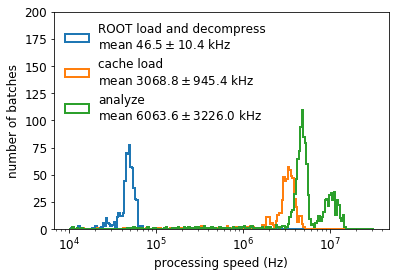

In [89]:
plt.hist(cc0, bins=bins, histtype="step", lw=2, label="ROOT load and decompress\nmean ${0:.1f} \pm {1:.1f}$ kHz".format(np.mean(cc0)/1000.0, np.std(cc0)/1000.0));
plt.hist(cc1, bins=bins, histtype="step", lw=2, label="cache load\nmean ${0:.1f} \pm {1:.1f}$ kHz".format(np.mean(cc1)/1000.0, np.std(cc1)/1000.0));
plt.hist(cc2, bins=bins, histtype="step", lw=2, label="analyze\nmean ${0:.1f} \pm {1:.1f}$ kHz".format(np.mean(cc2)/1000.0, np.std(cc2)/1000.0));
plt.xscale("log")
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.ylabel("number of batches", fontsize=12)
plt.xlabel("processing speed (Hz)", fontsize=12)
plt.legend(loc=2, frameon=False, fontsize=12)
plt.ylim(0,200)

In [90]:
def get_cache_analyze_speed(logpath):
    cc1 = []
    cc2 = []
    for li in open(logpath).readlines():
        if "from_cache:" in li:
            spl = li.split()
            cc1 += [float(spl[spl.index("speed")+1])]
        elif "analyze:" in li:
            spl = li.split()
            cc2 += [float(spl[spl.index("Hz,")-1])]
    return cc1, cc2

In [92]:
s0 = get_cache_analyze_speed("../log_nt16.txt")
s1 = get_cache_analyze_speed("../log_nt16_cuda_c1.txt.txt")

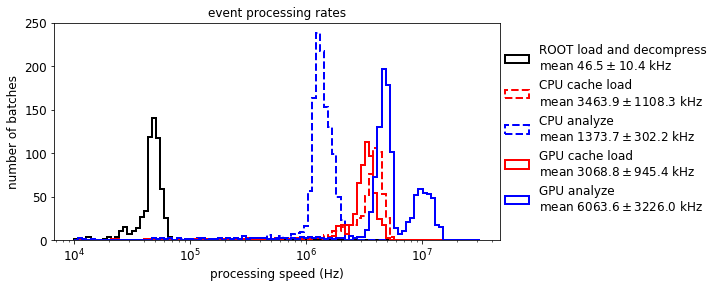

In [112]:
plt.figure(figsize=(8,4))
bins = np.logspace(4,7.5, 100)
plt.hist(cc0, bins=bins, histtype="step", color="black", lw=2, label="ROOT load and decompress\nmean ${0:.1f} \pm {1:.1f}$ kHz".format(np.mean(cc0)/1000.0, np.std(cc0)/1000.0));

plt.hist(s0[0], bins=bins, histtype="step", color="red", ls="--", lw=2, label="CPU cache load\nmean ${0:.1f} \pm {1:.1f}$ kHz".format(np.mean(s0[0])/1000.0, np.std(s0[0])/1000.0));
plt.hist(s0[1], bins=bins, histtype="step", color="blue", ls="--", lw=2, label="CPU analyze\nmean ${0:.1f} \pm {1:.1f}$ kHz".format(np.mean(s0[1])/1000.0, np.std(s0[1])/1000.0));

plt.hist(s1[0], bins=bins, histtype="step", color="red", lw=2, label="GPU cache load\nmean ${0:.1f} \pm {1:.1f}$ kHz".format(np.mean(s1[0])/1000.0, np.std(s1[0])/1000.0));
plt.hist(s1[1], bins=bins, histtype="step", color="blue", lw=2, label="GPU analyze\nmean ${0:.1f} \pm {1:.1f}$ kHz".format(np.mean(s1[1])/1000.0, np.std(s1[1])/1000.0));


plt.xscale("log")
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.ylabel("number of batches", fontsize=12)
plt.xlabel("processing speed (Hz)", fontsize=12)
plt.legend(loc=(1.0,0.1), frameon=False, fontsize=12)
plt.title("event processing rates")
plt.savefig("procrates.pdf", bbox_inches="tight")
#plt.ylim(0,200)

(0, 200)

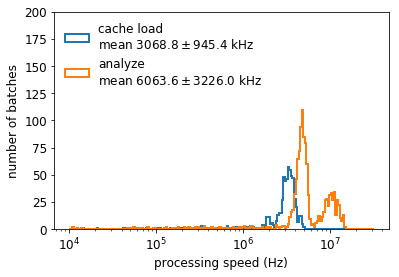

In [95]:
plt.xscale("log")
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.ylabel("number of batches", fontsize=12)
plt.xlabel("processing speed (Hz)", fontsize=12)
plt.legend(loc=2, frameon=False, fontsize=12)
plt.ylim(0,200)